In [2]:
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
params = {
    'batch_size':  16,
    'num_workers': 2,
    'device':   'cpu',
    'num_epochs': 4,
    'learning_rate': 0.0001,
    'weight_decay': 5e-4,
}
transform = transforms.ToTensor()
## Train
trainset = torchvision.datasets.MNIST('../data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=params['num_workers'])
### Test 
testset = torchvision.datasets.MNIST('../data', 
                                     train=False, 
                                     download=True, 
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=params['batch_size'], 
                                         shuffle=False, 
                                         num_workers=params['num_workers'])

In [4]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
testloader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

tensor([4, 5, 1, 8, 1, 4, 0, 6, 5, 1, 4, 7, 7, 2, 0, 0])


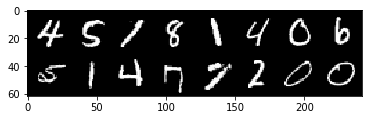

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)
show_batch(images)

In [8]:
## Simple MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(params['batch_size'], -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

In [9]:
NUM_LABELS = len(list(set(trainloader.dataset.train_labels.numpy())))
INPUT_SIZE = trainloader.dataset.train_data[0].flatten().shape[0]
HIDDEN_SIZE = 32
model = MLP(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
model

MLP(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [10]:
def train(model, trainloader, criterion, optimizer, n_epochs=10):
    for t in range(n_epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step()

            if not i % 2000:
                print("    --> EPOCH {}, ITER {}, LOSS {}".format(t, i, loss.data.numpy()))

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
train(model, trainloader, criterion, optimizer, n_epochs = params['num_epochs'])

    --> EPOCH 0, ITER 0, LOSS 2.2545182704925537
    --> EPOCH 0, ITER 2000, LOSS 0.3851430118083954
    --> EPOCH 1, ITER 0, LOSS 0.40532955527305603
    --> EPOCH 1, ITER 2000, LOSS 0.18953414261341095
    --> EPOCH 2, ITER 0, LOSS 0.2696727514266968
    --> EPOCH 2, ITER 2000, LOSS 0.2467522770166397
    --> EPOCH 3, ITER 0, LOSS 0.11839373409748077
    --> EPOCH 3, ITER 2000, LOSS 0.07464257627725601


In [12]:
def predict(model, images):
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    return predicted

LABELS: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
PREDICTION:  [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5]


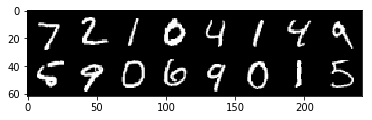

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print("LABELS: {}".format(labels.numpy()))
print('PREDICTION: ', predict(model, images).numpy())
show_batch(images)

In [14]:
def test(model, testloader):
    correct = 0
    for data in testloader:
        inputs, labels = data
        pred = predict(model, inputs)
        correct += (pred == labels).sum()
    return 100 * correct / len(testset)

In [15]:
print('ACCURACY: {}%'.format(test(model, testloader).numpy()))

ACCURACY: 92%


## Using Weight Pruning

In [16]:
params = {
    'pruning_perc': 85.,
    'batch_size': 16, 
    'test_batch_size': 100,
    'num_epochs': 4,
    'learning_rate': 0.001,
    'weight_decay': 5e-4,
}

In [542]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.register_buffer('mask', mask)
        mask_var = self.get_mask()
        self.weight.data = self.weight.data*mask_var.data
        self.mask_flag = True
    
    def get_mask(self):
        return self.mask.clone().detach().requires_grad_(False)
    
    def set_sign(self, mask):
        self.register_buffer('mask', mask)
        mask_var = self.get_mask()
        self.weight.data = self.weight.data*mask_var.data
        self.mask_flag = True
    
    def forward(self, x):
        if self.mask_flag == True:
            mask_var = self.get_mask()
            weight = self.weight * mask_var
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [627]:
## Simple MLP
class MLP_weight_prunning(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        super(MLP_weight_prunning, self).__init__()
        self.linear1 = MaskedLinear(input_size, hidden_size)
        self.linear2 = MaskedLinear(hidden_size, num_labels)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(params['batch_size'], -1)))
        y_pred = self.linear2(h_relu)
        return y_pred
    def set_masks(self, masks):
    # Should be a less manual way to set masks
    # Leave it for the future
        self.linear1.set_mask(masks[0])
        self.linear2.set_mask(masks[1])

    def set_signs(self, signs):
        sign_1 = torch.FloatTensor(signs[0]).view(self.linear1.weight.data.shape[0],-1)
        sign_2 = torch.FloatTensor(signs[1]).view(self.linear2.weight.data.shape[0],-1)
        self.linear1.weight.data = torch.mul(self.linear1.weight.data.abs(),sign_1)
        self.linear2.weight.data = torch.mul(self.linear2.weight.data.abs(),sign_2)

In [628]:
NUM_LABELS = len(list(set(trainloader.dataset.train_labels.numpy())))
INPUT_SIZE = trainloader.dataset.train_data[0].flatten().shape[0]
HIDDEN_SIZE = 32

model_2 = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
print('ACCURACY: {}%'.format(test(model_2, testloader).numpy()))
model_2

ACCURACY: 8%


MLP_weight_prunning(
  (linear1): MaskedLinear(in_features=784, out_features=32, bias=True)
  (linear2): MaskedLinear(in_features=32, out_features=10, bias=True)
)

In [629]:
print(model_2.linear1.weight.data.shape)
model_2.linear1.weight.data

torch.Size([32, 784])


tensor([[ 0.0349, -0.0129,  0.0093,  ...,  0.0250, -0.0189, -0.0086],
        [-0.0081, -0.0293,  0.0156,  ..., -0.0273,  0.0095, -0.0317],
        [ 0.0005, -0.0098,  0.0086,  ..., -0.0343, -0.0165, -0.0339],
        ...,
        [-0.0169, -0.0178,  0.0075,  ..., -0.0261, -0.0328, -0.0327],
        [-0.0065, -0.0161, -0.0188,  ...,  0.0282,  0.0091,  0.0228],
        [ 0.0059, -0.0112,  0.0106,  ..., -0.0102,  0.0350, -0.0260]])

In [630]:
np.percentile(model_2.linear1.weight.data.numpy(),90)

0.028477662056684488

In [631]:
print(model_2.linear2.weight.data.shape)
model_2.linear2.weight.data

torch.Size([10, 32])


tensor([[ 0.0298, -0.1383, -0.1301, -0.1223,  0.0491,  0.1480,  0.1223,  0.0362,
         -0.1300, -0.1103, -0.0202, -0.1172, -0.0655, -0.0519,  0.1018, -0.1428,
          0.0657, -0.0182, -0.0216,  0.0601, -0.1246,  0.0615, -0.0130,  0.0409,
          0.1607,  0.1085,  0.0392,  0.1421, -0.0482,  0.1009,  0.0470, -0.1307],
        [-0.0809, -0.1390,  0.1033, -0.0051,  0.1608,  0.0263, -0.1739,  0.1182,
          0.0134,  0.0046,  0.0973,  0.0576, -0.1726,  0.0654,  0.1368,  0.1605,
         -0.1497,  0.0848, -0.0888,  0.0594, -0.1656, -0.1056, -0.0360, -0.0208,
         -0.0540,  0.0725,  0.0303, -0.0698,  0.1334,  0.1089,  0.0125, -0.1417],
        [ 0.0115,  0.1046,  0.0507, -0.1003,  0.0648,  0.0938, -0.0131, -0.1573,
         -0.1383, -0.1070, -0.1045, -0.1504, -0.0867, -0.0615,  0.1768, -0.1470,
          0.0672,  0.1212,  0.1234,  0.1599, -0.1705, -0.1590,  0.0530,  0.0129,
         -0.0805,  0.0892, -0.0137, -0.0158,  0.0238,  0.1108,  0.0804,  0.0617],
        [ 0.0478, -0.1222

In [632]:
def weight_prune(model, pruning_perc):
    '''
    Prune pruning_perc% weights globally (not layer-wise)
    arXiv: 1606.09274
    '''    
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
        ## Skip bias layers
            all_weights += list(p.cpu().data.abs().numpy().flatten())
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    print("Threshold value: {}".format(threshold))
    # generate mask
    masks = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            
            masks.append(pruned_inds.float())
    return masks

In [671]:
def weight_prune_3(model, pruning_perc):
    '''
    Prune pruning_perc% weights globally (not layer-wise)
    arXiv: 1606.09274
    '''    
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
        ## Skip bias layers
            all_weights += list(p.cpu().data.abs().numpy().flatten())
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    print("Threshold value: {}".format(threshold))
    # generate mask
    masks = []
    signs = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            signs_inds = np.sign(p.data)
            masks.append(pruned_inds.float())
            signs.append(signs_inds)
    return masks, signs

In [633]:
def weight_prune_2(model, pruning_perc, prune_method = 'large final'): 
    all_masks = []
    for p in model.parameters():
        mask = []
        if len(p.data.size()) != 1:
        ## Skip bias layers
            weights = list(p.cpu().data.abs().numpy().flatten())
            threshold = np.percentile(np.array(weights), pruning_perc)
            pruned_inds = p.data.abs() > threshold
            all_masks.append(pruned_inds.float())
    return all_masks

In [634]:
def get_weights(model):
    all_weights = []
    all_weights_sign =[]
    for p in model.parameters():
        if len(p.data.size()) != 1:
            weights = list(p.cpu().data.numpy().flatten())
            weights_sign = [1 if x>0 else -1 for x in weights]
            all_weights.append(weights)
            all_weights_sign.append(weights_sign)
    return all_weights, all_weights_sign

In [635]:
def count_zeros_percentage(vec):
    return np.count_nonzero(vec.flatten()==0)/vec.flatten().shape[0]
def count_zeros_percentage_list(vec):
    return np.count_nonzero(np.array(vec)==0.0)/len(vec)

In [636]:
def prune_model(model, pruning_perc):
    mask_prune = weight_prune(model, pruning_perc)
    model.set_masks(mask_prune)
    return model, mask_pruned

## Plot Weights

In [679]:
model_plot = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
print('ACCURACY: {}%'.format(test(model_plot, testloader).numpy()))

ACCURACY: 14%


In [674]:
model_plot.linear1.weight.data

tensor([[-0.0067, -0.0279,  0.0224,  ..., -0.0251,  0.0203, -0.0265],
        [ 0.0220,  0.0340,  0.0264,  ...,  0.0130, -0.0250, -0.0235],
        [-0.0157, -0.0335,  0.0132,  ..., -0.0241, -0.0289, -0.0312],
        ...,
        [ 0.0248, -0.0140,  0.0356,  ...,  0.0211, -0.0356,  0.0178],
        [-0.0347,  0.0295,  0.0334,  ...,  0.0146,  0.0291,  0.0226],
        [-0.0297,  0.0002, -0.0266,  ..., -0.0270, -0.0195, -0.0324]])

In [676]:
weight_prune_3(model_plot, 90)[1][0]

Threshold value: 0.032376953586936


tensor([[-1., -1.,  1.,  ..., -1.,  1., -1.],
        [ 1.,  1.,  1.,  ...,  1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        [-1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])

In [669]:
weight_prune_3(model_plot, 90)

Threshold value: 0.03247556202113628


torch.Size([10, 32])

In [638]:
len(get_weights(model_plot)[1][0]),len(get_weights(model_plot)[1][1])

(25088, 320)

Threshold value: 0.025348798744380473
ACCURACY: 10%


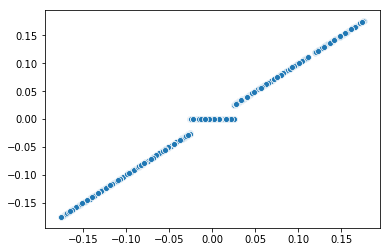

In [639]:
model_plot_pruned, _ = prune_model(model_plot, 70)
weights_pruned_untrained, sign_pruned_untrained  = get_weights(model_plot_pruned)
print('ACCURACY: {}%'.format(test(model_plot_pruned, testloader).numpy()))
sns.scatterplot(weights_original[0]+weights_original[1], weights_pruned_untrained[0] + weights_pruned_untrained[1] )

In [640]:
weights_pruned_untrained

[[0.0,
  -0.0,
  0.0,
  0.026880655,
  -0.0,
  -0.0,
  0.0,
  -0.030189907,
  0.0,
  0.025617417,
  0.0,
  0.0,
  0.027307238,
  -0.0,
  -0.0,
  0.0,
  -0.0,
  0.029161971,
  0.03217468,
  -0.0,
  -0.0,
  -0.027813878,
  0.0,
  0.032255355,
  0.0,
  -0.03528119,
  -0.0,
  0.03215148,
  -0.03298431,
  0.0,
  -0.0,
  0.03473464,
  0.0,
  -0.0,
  -0.02724683,
  -0.035219923,
  0.0,
  0.0,
  -0.0,
  0.0,
  0.027050387,
  -0.031426296,
  0.028666604,
  -0.028864816,
  0.028731313,
  0.034614783,
  -0.0,
  0.0,
  0.0,
  -0.0,
  -0.0,
  -0.0,
  0.0,
  0.032404657,
  0.034121167,
  -0.0,
  -0.0285375,
  0.0,
  -0.0,
  0.026144058,
  -0.0,
  0.0,
  0.027863156,
  -0.0,
  -0.0,
  0.0,
  0.0,
  0.0,
  -0.0,
  -0.0,
  -0.027780376,
  -0.031062463,
  -0.027077243,
  -0.0,
  -0.0,
  0.0,
  0.029229108,
  0.025424082,
  -0.026253663,
  -0.0,
  0.027551036,
  -0.0,
  0.0,
  -0.0,
  -0.03487801,
  -0.0,
  0.0,
  0.032299142,
  0.0,
  0.0,
  -0.0,
  -0.029328922,
  -0.0,
  0.0,
  0.0,
  0.0,
  -0.0,
  -

In [641]:
sign_pruned_untrained

[[-1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,

In [642]:
model_plot_pruned.linear1.weight.data

tensor([[ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0274,  ...,  0.0000,  0.0324,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -0.0290],
        [ 0.0000, -0.0356, -0.0280,  ..., -0.0000,  0.0258,  0.0000],
        [ 0.0000,  0.0000, -0.0357,  ..., -0.0258, -0.0000,  0.0000]])

In [645]:
sign_pruned_untrained

[[-1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,

In [643]:
model_plot_pruned.set_signs(sign_pruned_untrained)

In [644]:
model_plot_pruned.linear1.weight.data

tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0274,  ..., -0.0000,  0.0324, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0290],
        [-0.0000, -0.0356, -0.0280,  ..., -0.0000,  0.0258, -0.0000],
        [-0.0000, -0.0000, -0.0357,  ..., -0.0258, -0.0000, -0.0000]])

In [646]:
## prune before training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_plot_pruned.parameters(), lr=params['learning_rate'])
train(model_plot_pruned, trainloader, criterion, optimizer, n_epochs = params['num_epochs'])

    --> EPOCH 0, ITER 0, LOSS 2.346040725708008
    --> EPOCH 0, ITER 2000, LOSS 0.18569126725196838
    --> EPOCH 1, ITER 0, LOSS 0.15917694568634033
    --> EPOCH 1, ITER 2000, LOSS 0.05825719237327576
    --> EPOCH 2, ITER 0, LOSS 0.11795569956302643
    --> EPOCH 2, ITER 2000, LOSS 0.3212544918060303
    --> EPOCH 3, ITER 0, LOSS 0.30169588327407837
    --> EPOCH 3, ITER 2000, LOSS 0.06529389321804047


ACCURACY: 94%


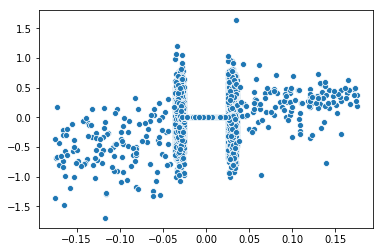

In [647]:
#model_plot_pruned, mask_pruned = prune_model(model_plot, 70)
weights_pruned_trained, signs_pruned_trained = get_weights(model_plot_pruned)
print('ACCURACY: {}%'.format(test(model_plot_pruned, testloader).numpy()))
sns.scatterplot(weights_original[0]+weights_original[1], weights_pruned_trained[0] + weights_pruned_trained[1] )

In [682]:
new_model = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
print('ACCURACY: {}%'.format(test(new_model, testloader).numpy()))

ACCURACY: 11%


In [683]:
new_model.set_signs(signs_pruned_trained)
print('ACCURACY: {}%'.format(test(new_model, testloader).numpy()))

ACCURACY: 9%


In [684]:
new_model.set_masks(weights_pruned_trained)
print('ACCURACY: {}%'.format(test(new_model, testloader).numpy()))

TypeError: cannot assign 'list' object to buffer 'mask' (torch Tensor or None required)

In [395]:
## Set Pruning Mask

In [340]:
## prune after training
model_plot = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
weights_original = get_weights(model_plot)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_plot.parameters(), lr=params['learning_rate'])
train(model_plot, trainloader, criterion, optimizer, n_epochs = params['num_epochs'])

    --> EPOCH 0, ITER 0, LOSS 2.2769532203674316
    --> EPOCH 0, ITER 2000, LOSS 0.2639976739883423
    --> EPOCH 1, ITER 0, LOSS 0.25814005732536316
    --> EPOCH 1, ITER 2000, LOSS 0.21426014602184296
    --> EPOCH 2, ITER 0, LOSS 0.06205340474843979
    --> EPOCH 2, ITER 2000, LOSS 0.05382224917411804
    --> EPOCH 3, ITER 0, LOSS 0.030260220170021057
    --> EPOCH 3, ITER 2000, LOSS 0.1975731998682022


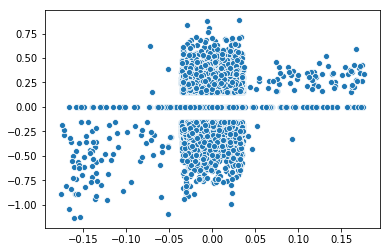

In [343]:
model_plot_pruned = prune_model(model_plot, 70)
weights_pruned_trained = get_weights(model_plot_pruned)
sns.scatterplot(weights_original, weights_pruned_trained )

### Train w/ Several Prune Rates

In [63]:
percentile_prune = [10, 20, 30, 50, 70, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
models_pruned = [prune_model(MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS), i) for i in percentile_prune]
optimizer = [optim.Adam(models_pruned[i].parameters(),lr=params['learning_rate']) for i in range(len(percentile_prune))]
losses = [nn.CrossEntropyLoss() for i in range(len(percentile_prune))]

In [87]:
accuracy_prune = []
for i, (model, opt, loss) in enumerate(zip(models_pruned, optimizer, losses)):
    print("Traning Prune {} %".format(percentile_prune[i]))
    train(model, trainloader, loss, opt, n_epochs = params['num_epochs'])
    accuracy = test(model, testloader).numpy()
    accuracy_prune.append(float(accuracy))
    print('    --> TEST ACCURACY: {}%'.format(accuracy))
    print('-'*50)

Traning Prune 10 %
    --> EPOCH 0, ITER 0, LOSS 2.3276727199554443
    --> EPOCH 0, ITER 2000, LOSS 0.406296044588089
    --> EPOCH 1, ITER 0, LOSS 0.08506131917238235
    --> EPOCH 1, ITER 2000, LOSS 0.24280472099781036
    --> EPOCH 2, ITER 0, LOSS 0.14864470064640045
    --> EPOCH 2, ITER 2000, LOSS 0.4815768599510193
    --> EPOCH 3, ITER 0, LOSS 0.00966443121433258
    --> EPOCH 3, ITER 2000, LOSS 0.00600762665271759
    --> TEST ACCURACY: 96%
--------------------------------------------------
Traning Prune 20 %
    --> EPOCH 0, ITER 0, LOSS 2.3313865661621094
    --> EPOCH 0, ITER 2000, LOSS 0.1482839435338974
    --> EPOCH 1, ITER 0, LOSS 0.21664130687713623
    --> EPOCH 1, ITER 2000, LOSS 0.04812510311603546
    --> EPOCH 2, ITER 0, LOSS 0.030375510454177856
    --> EPOCH 2, ITER 2000, LOSS 0.06472866982221603
    --> EPOCH 3, ITER 0, LOSS 0.05569863319396973
    --> EPOCH 3, ITER 2000, LOSS 0.12200148403644562
    --> TEST ACCURACY: 96%
--------------------------------------

In [56]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Test Accuracy %'), Text(0.5, 0, 'Prune %')]

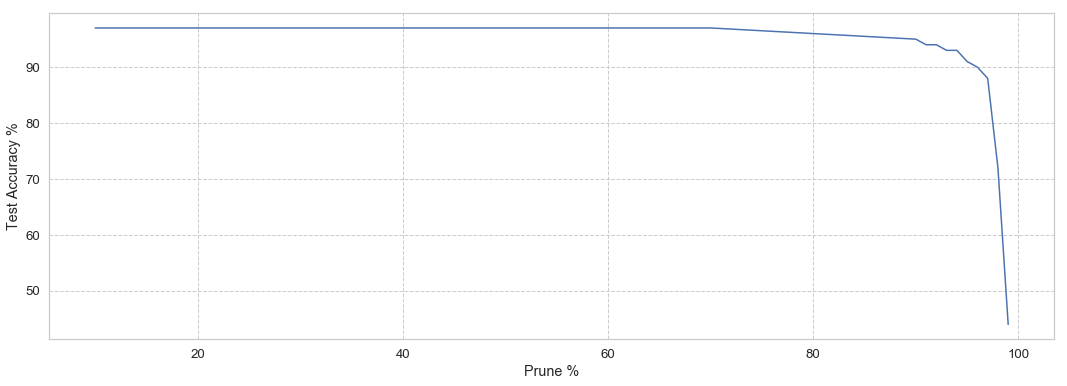

In [57]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(percentile_prune, accuracy_prune)
ax.set(xlabel='Prune %', ylabel='Test Accuracy %')

In [58]:
for mod in models_pruned:
    print(count_zeros_percentage(mod.linear1.weight.data.numpy()),count_zeros_percentage(mod.linear2.weight.data.numpy()))
    print('ACCURACY: {}%'.format(test(mod, testloader).numpy()))

0.10000298947704081 0.1
ACCURACY: 97%
0.20000099649234693 0.2
ACCURACY: 97%
0.2999990035076531 0.3
ACCURACY: 97%
0.5 0.5
ACCURACY: 97%
0.7000009964923469 0.7
ACCURACY: 97%
0.8999970105229592 0.9
ACCURACY: 95%
0.9099968112244898 0.909765625
ACCURACY: 94%
0.9199966119260204 0.919921875
ACCURACY: 94%
0.9299964126275511 0.9296875
ACCURACY: 93%
0.9399962133290817 0.93984375
ACCURACY: 93%
0.9499960140306123 0.95
ACCURACY: 91%
0.9599958147321429 0.959765625
ACCURACY: 90%
0.9699956154336735 0.969921875
ACCURACY: 88%
0.9799954161352041 0.9796875
ACCURACY: 72%
0.9899952168367347 0.98984375
ACCURACY: 44%


## Other Mask Methods

## References
[1] https://github.com/zepx/pytorch-weight-prune/blob/develop/weight_pruning.py